# A simple notebook to compute some statistics about theses in DiVA examined by Gerald Q. Maguire Jr.

The program fetches data from DiVA as a feed, using the URL shown as 'url' below. Unlike the previous program, this program fetches the data as a CSV feed (specifically "CSV all metadata version 2").

## Get some data and start processing it

In [1]:
# compute statistics over thesis data from DiVA Start
# libraries
import json
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime
from io import StringIO

# define a function to computer lower case Roman numeras from an integer
def int_to_roman(num):
    res = ""
    table = [
        (1000, "m"),
        (900, "cm"),
        (500, "d"),
        (400, "cd"),
        (100, "c"),
        (90, "xc"),
        (50, "l"),
        (40, "xl"),
        (10, "x"),
        (9, "ix"),
        (5, "v"),
        (4, "iv"),
        (1, "i"),
    ]
    for cap, roman in table:
        d, m = divmod(num, cap)
        res += roman * d
        num = m
    return res

# Using the above function fill a dict with the lower case Roman numerals from 0 to 499
roman_table=dict()
for i in range(0,500):
    roman_table[int_to_roman(i)]=i


# URL of the DiVA feed
# The starting year is arbitrarly fixed to 1990 - as I had no degree projects a KTH prior to this.
current_year = date.today().year
examiner='maguire'
# the maximum number of theses was arbitrarily set to 5000
url='https://kth.diva-portal.org/smash/export.jsf?format=csvall2&addFilename=true&aq=[[{"examiner":["maguire"]}]]&aqe=[]&aq2=[[{"dateIssued":{"from":"1990","to":"2022"}},{"publicationTypeCode":["studentThesis"]}]]&onlyFullText=false&noOfRows=5000&sortOrder=title_sort_asc&sortOrder2=title_sort_asc'

req = urllib.request.Request(url)
resource=urllib.request.urlopen(req)
data_str=StringIO(resource.read().decode(resource.headers.get_content_charset()))

# This cleanup is necessary for a CSL-JSON feed, but not for a CSV feed
# do some data cleanup
#data_str=data_str.replace('\n', '\\n')
#data_str=data_str.replace('\\hbox', '\\\\hbox')
#data_str=data_str.replace('\\(', '(')
#data_str=data_str.replace('\\)', ')')
#data_str=data_str.replace('\\approx', '~')
#data_str=data_str.replace('\\%', '%')
#data_str=data_str.replace('\t', '')
#data_str=data_str.replace('\\Omega', 'Omega')

#data = json.loads(data_str)
#df = pd.DataFrame(data)
df=pd.read_csv(data_str, sep=",")
#print(df.head())



## Calculate the total number of pages in each thesis

In [2]:
for idx, row in df.iterrows():
    pages=row['Pages']
    if isinstance(pages, str) and ',' in pages:
        #print(pages)
        preface, body = pages.split(',')
        df.loc[idx, 'total_pages']=roman_table[preface]+int(body)
    elif isinstance(pages, str) and '.' in pages:
        #print(pages)
        preface, body = pages.split('.')
        df.loc[idx, 'total_pages']=roman_table[preface]+int(body)
    elif isinstance(pages, str):
        df.loc[idx, 'total_pages']=int(pages)
    else:
        df.loc[idx, 'total_pages']=0


# show the total_pages values as a plot
bins=[]
for b in range(0, round(int(df['total_pages'].max()+50), -1), 10):
    bins.append(b)
print("total_pages mas={}".format(df['total_pages'].max()))
#df[['total_pages']] = df[['total_pages']].apply(pd.to_numeric)
#hist_tp=plt.hist(df['total_pages'], bins=bins)
freq_df=pd.DataFrame(df['total_pages'].value_counts(bins=bins))
freq_df=freq_df.reset_index()
freq_df.columns=['number of pages', 'count']
for idx, row in freq_df.iterrows():
 	freq_df.loc[idx, 'base']=row['number of pages'].left

freq_df.sort_values(by='base', ignore_index=True, ascending=True)
freq_df = freq_df.drop('number of pages', axis=1)


total_pages mas=455.0


From the histogram below, we can see that there are a number of theses that did not have a length in DiVA and these have been interpreted has having zero, i.e., 0, lenght. One can easily see that the distribut is pretty well 

In [3]:
_deepnote_run_altair(freq_df, """{"data":{"name":"placeholder"},"mark":{"type":"bar","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"bin":false,"sort":{"order":"ascending","encoding":"x"},"type":"quantitative","field":"base","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"count","scale":{"type":"linear","zero":true}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

Calculate and show some additional statistics such as PDF an CDF.

In [4]:
# Frequency
stats_df = df \
.groupby('total_pages') \
['total_pages'] \
.agg('count') \
.pipe(pd.DataFrame) \
.rename(columns = {'total_pages': 'frequency'})

# PDF
stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

# CDF
stats_df['cdf'] = stats_df['pdf'].cumsum()
stats_df = stats_df.reset_index()
stats_df

total_pages  frequency       pdf       cdf
0            0.0         36  0.061538  0.061538
1           16.0          1  0.001709  0.063248
2           18.0          2  0.003419  0.066667
3           24.0          3  0.005128  0.071795
4           26.0          1  0.001709  0.073504
..           ...        ...       ...       ...
131        251.0          1  0.001709  0.993162
132        269.0          1  0.001709  0.994872
133        271.0          1  0.001709  0.996581
134        377.0          1  0.001709  0.998291
135        455.0          1  0.001709  1.000000

[136 rows x 4 columns]

In [5]:
_deepnote_run_altair(stats_df, """{"data":{"name":"placeholder"},"mark":{"type":"bar","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"pdf","scale":{"type":"linear","zero":true}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [6]:
_deepnote_run_altair(stats_df, """{"data":{"name":"placeholder"},"mark":{"type":"line","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"cdf","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [7]:
_deepnote_run_altair(df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [8]:
_deepnote_run_altair(df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"total_pages","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

## Make a word cloud based on the first half of the keywords

To make word clouds you need to install the wordcloud package into your compute (or the firstual computer). In the case of deepnote you can add to the requirements.tx file a list of version of the packages that you need, in this case a line saying:

wordcloud==1.8.2.2

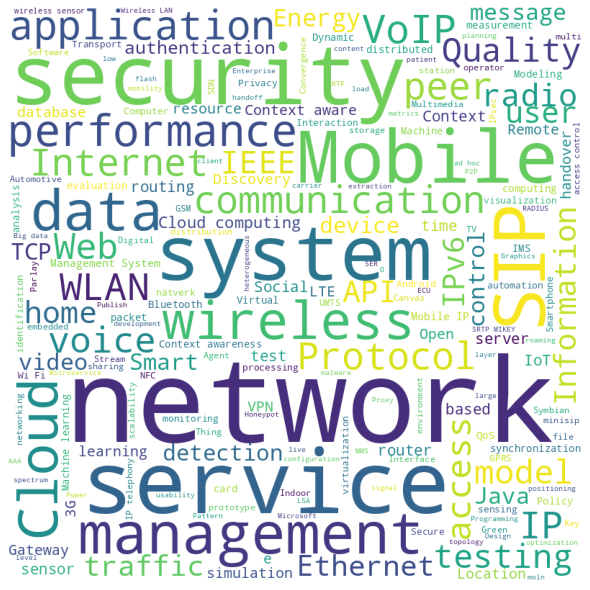

In [9]:
from wordcloud import WordCloud, STOPWORDS
comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('nan')

for val in df['Keywords']:
    val = str(val)
    # split the value
    tokens = val.split(';')
    number_of_tokens=len(tokens)
    # choose the first half of the tokens, as they are probably in the same language
    if number_of_tokens % 2 == 0:
        tokens=tokens[0:int(number_of_tokens/2)]
    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Make a word cloud based on the second half of the keywords (which are likely to be in Swedish)

This list of Swedish stopwords was computed in an earlier project that I did looking at thesis abstracts. See the program check_abstracts.py in https://github.com/gqmaguirejr/DiVA-tools .

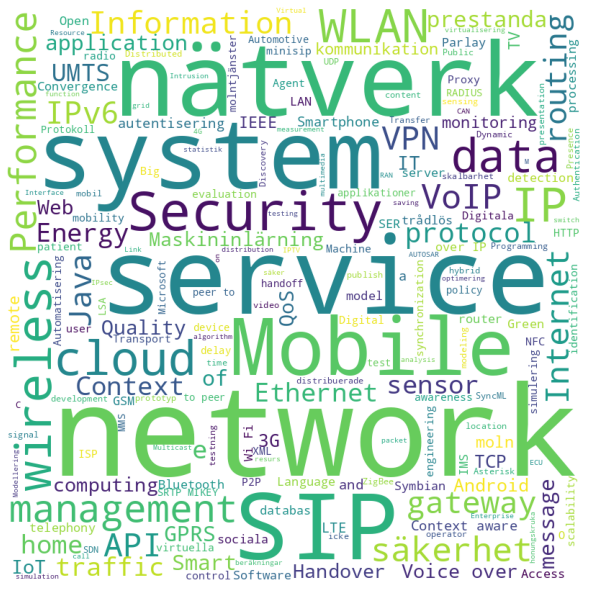

In [10]:
SwedishStopWords=[
    u'aderton',
    u'adertonde',
    u'adjö',
    u'aldrig',
    u'alla',
    u'allas',
    u'allt',
    u'alltid',
    u'alltså',
    u'än',
    u'andra',
    u'andras',
    u'annan',
    u'annat',
    u'ännu',
    u'artonde',
    u'artonn',
    u'åtminstone',
    u'att',
    u'åtta',
    u'åttio',
    u'åttionde',
    u'åttonde',
    u'av',
    u'även',
    u'båda',
    u'bådas',
    u'bakom',
    u'bara',
    u'bäst',
    u'bättre',
    u'behöva',
    u'behövas',
    u'behövde',
    u'behövt',
    u'beslut',
    u'beslutat',
    u'beslutit',
    u'bland',
    u'blev',
    u'bli',
    u'blir',
    u'blivit',
    u'bort',
    u'borta',
    u'bra',
    u'då',
    u'dag',
    u'dagar',
    u'dagarna',
    u'dagen',
    u'där',
    u'därför',
    u'de',
    u'del',
    u'delen',
    u'dem',
    u'den',
    u'deras',
    u'dess',
    u'det',
    u'detta',
    u'dig',
    u'din',
    u'dina',
    u'dit',
    u'ditt',
    u'dock',
    u'du',
    u'efter',
    u'eftersom',
    u'elfte',
    u'eller',
    u'elva',
    u'en',
    u'enkel',
    u'enkelt',
    u'enkla',
    u'enligt',
    u'er',
    u'era',
    u'ert',
    u'ett',
    u'ettusen',
    u'få ',
    u'fanns',
    u'får',
    u'fått ',
    u'fem',
    u'femte',
    u'femtio',
    u'femtionde',
    u'femton',
    u'femtonde',
    u'fick',
    u'fin',
    u'finnas',
    u'finns',
    u'fjärde',
    u'fjorton',
    u'fjortonde',
    u'fler',
    u'flera',
    u'flesta',
    u'följande',
    u'för',
    u'före',
    u'förlåt',
    u'förra',
    u'första',
    u'fram',
    u'framför',
    u'från',
    u'fyra',
    u'fyrtio',
    u'fyrtionde',
    u'gå',
    u'gälla',
    u'gäller',
    u'gällt',
    u'går',
    u'gärna',
    u'gått',
    u'genast',
    u'genom',
    u'gick',
    u'gjorde',
    u'gjort',
    u'god',
    u'goda',
    u'godare',
    u'godast',
    u'gör',
    u'göra',
    u'gott',
    u'ha',
    u'hade',
    u'haft',
    u'han',
    u'hans',
    u'har',
    u'här',
    u'heller',
    u'hellre',
    u'helst',
    u'helt',
    u'henne',
    u'hennes',
    u'hit',
    u'hög',
    u'höger',
    u'högre',
    u'högst',
    u'hon',
    u'honom',
    u'hundra',
    u'hundraen',
    u'hundraett',
    u'hur',
    u'i',
    u'ibland',
    u'idag',
    u'igår',
    u'igen',
    u'imorgon',
    u'in',
    u'inför',
    u'inga',
    u'ingen',
    u'ingenting',
    u'inget',
    u'innan',
    u'inne',
    u'inom',
    u'inte',
    u'inuti',
    u'ja',
    u'jag',
    u'jämfört',
    u'kan',
    u'kanske',
    u'knappast',
    u'kom',
    u'komma',
    u'kommer',
    u'kommit',
    u'kr',
    u'kunde',
    u'kunna',
    u'kunnat',
    u'kvar',
    u'länge',
    u'längre',
    u'långsam',
    u'långsammare',
    u'långsammast',
    u'långsamt',
    u'längst',
    u'långt',
    u'lätt',
    u'lättare',
    u'lättast',
    u'legat',
    u'ligga',
    u'ligger',
    u'lika',
    u'likställd',
    u'likställda',
    u'lilla',
    u'lite',
    u'liten',
    u'litet',
    u'man',
    u'många',
    u'måste',
    u'med',
    u'mellan',
    u'men',
    u'mer',
    u'mera',
    u'mest',
    u'mig',
    u'min',
    u'mina',
    u'mindre',
    u'minst',
    u'mitt',
    u'mittemot',
    u'möjlig',
    u'möjligen',
    u'möjligt',
    u'möjligtvis',
    u'mot',
    u'mycket',
    u'någon',
    u'någonting',
    u'något',
    u'några',
    u'när',
    u'nästa',
    u'ned',
    u'nederst',
    u'nedersta',
    u'nedre',
    u'nej',
    u'ner',
    u'ni',
    u'nio',
    u'nionde',
    u'nittio',
    u'nittionde',
    u'nitton',
    u'nittonde',
    u'nödvändig',
    u'nödvändiga',
    u'nödvändigt',
    u'nödvändigtvis',
    u'nog',
    u'noll',
    u'nr',
    u'nu',
    u'nummer',
    u'och',
    u'också',
    u'ofta',
    u'oftast',
    u'olika',
    u'olikt',
    u'om',
    u'oss',
    u'över',
    u'övermorgon',
    u'överst',
    u'övre',
    u'på',
    u'rakt',
    u'rätt',
    u'redan',
    u'så',
    u'sade',
    u'säga',
    u'säger',
    u'sagt',
    u'samma',
    u'sämre',
    u'sämst',
    u'sedan',
    u'senare',
    u'senast',
    u'sent',
    u'sex',
    u'sextio',
    u'sextionde',
    u'sexton',
    u'sextonde',
    u'sig',
    u'sin',
    u'sina',
    u'sist',
    u'sista',
    u'siste',
    u'sitt',
    u'sjätte',
    u'sju',
    u'sjunde',
    u'sjuttio',
    u'sjuttionde',
    u'sjutton',
    u'sjuttonde',
    u'ska',
    u'skall',
    u'skulle',
    u'slutligen',
    u'små',
    u'smått',
    u'snart',
    u'som',
    u'stor',
    u'stora',
    u'större',
    u'störst',
    u'stort',
    u'tack',
    u'tidig',
    u'tidigare',
    u'tidigast',
    u'tidigt',
    u'till',
    u'tills',
    u'tillsammans',
    u'tio',
    u'tionde',
    u'tjugo',
    u'tjugoen',
    u'tjugoett',
    u'tjugonde',
    u'tjugotre',
    u'tjugotvå',
    u'tjungo',
    u'tolfte',
    u'tolv',
    u'tre',
    u'tredje',
    u'trettio',
    u'trettionde',
    u'tretton',
    u'trettonde',
    u'två',
    u'tvåhundra',
    u'under',
    u'upp',
    u'ur',
    u'ursäkt',
    u'ut',
    u'utan',
    u'utanför',
    u'ute',
    u'vad',
    u'vänster',
    u'vänstra',
    u'var',
    u'vår',
    u'vara',
    u'våra',
    u'varför',
    u'varifrån',
    u'varit',
    u'varken',
    u'värre',
    u'varsågod',
    u'vart',
    u'vårt',
    u'vem',
    u'vems',
    u'verkligen',
    u'vi',
    u'vid',
    u'vidare',
    u'viktig',
    u'viktigare',
    u'viktigast',
    u'viktigt',
    u'vilka',
    u'vilken',
    u'vilket',
    u'vill',
    ]
    
swedish_comment_words = ''
stopwords = set(SwedishStopWords)
stopwords.add('nan')

for val in df['Keywords']:
    val = str(val)
    # split the value
    tokens = val.split(';')
    number_of_tokens=len(tokens)
    # choose the second half of the tokens, as they are probably in the same language
    if number_of_tokens % 2 == 0:
        tokens=tokens[int(number_of_tokens/2)+1:]
    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    swedish_comment_words += " ".join(tokens)+" "
 
swedishwordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(swedish_comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(swedishwordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Calculate some statistics on the dates: DefenceDate, CreatedDate,  and PublicationDate

One of the ideas of this part of the analysis was to show that one can create the columns of a Python Pandas dataframe to have the date types that you want. Another idea of this part of the notebook was to look at the time intervals between the oral presentation (defenceDate) and the creation of the DiVA page and when the DiVA page was published.

In [11]:
# do some statistics on the dates: DefenceDate, CreatedDate,  and PublicationDate

number_with_defenceDate=0
number_with_createdDate=0
number_with_publicationDate=0

dates_df=pd.DataFrame({
    'PID': pd.Series(dtype='int'),
    'Year': pd.Series(dtype='int'),
    'DefenceDate': pd.Series(dtype='datetime64[ns]'),
    'CreatedDate': pd.Series(dtype='datetime64[ns]'),
    'PublicationDate': pd.Series(dtype='datetime64[ns]'),
    'delta_created': pd.Series(dtype='int'),
    'delta_publication': pd.Series(dtype='int')
})

for idx, row in df.iterrows():
    defense_date=None
    created_date=None
    publication_date=None
    year=None

    pid=str(row['PID'])
    dates_df.loc[idx,'PID']=int(pid)
    year=str(row['Year'])
    if year:
        dates_df.loc[idx,'Year']=int(year)

    defense_date_str=str(row['DefenceDate']) # will have the form: 2022-05-24T13:00
    if len(defense_date_str) == 16:
        # convert the string into a python date and time
        defense_date=datetime.strptime(defense_date_str, '%Y-%m-%dT%H:%M')
        dates_df.loc[idx,'DefenceDate']=defense_date
        number_with_defenceDate=number_with_defenceDate+1

    created_date_str=str(row['CreatedDate'])
    if len(created_date_str) == 10:
        #
        created_date=datetime.strptime(created_date_str, '%Y-%m-%d')
        dates_df.loc[idx,'CreatedDate']=created_date
        number_with_createdDate=number_with_createdDate+1

    publication_date_str=str(row['PublicationDate'])
    if len(publication_date_str) == 10:
        #
        publication_date=datetime.strptime(publication_date_str, '%Y-%m-%d')
        dates_df.loc[idx,'PublicationDate']=publication_date
        number_with_publicationDate=number_with_publicationDate+1
    
    if defense_date and created_date:
        dates_df.loc[idx,'delta_created']=int((created_date-defense_date).days)
    if created_date and publication_date:
        dates_df.loc[idx,'delta_publication']=int((publication_date-created_date).days)

print("number_with_defenceDate={0}, number_with_createdDate={1},number_with_publicationDate={2}".format(number_with_defenceDate, number_with_createdDate, number_with_publicationDate))
                     

number_with_defenceDate=533, number_with_createdDate=585,number_with_publicationDate=585


In [12]:
_deepnote_run_altair(dates_df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"time","zero":false}},"y":{"sort":null,"type":"quantitative","field":"delta_publication","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

As shown in the plot below, the time between the defense and the creation of the record in DiVA goes down rather rapidly in 2012, when I started putting the meta data for all of the old theses that I had previously had into DiVA. After this point the time between the defence and the creation of a record in DiVA is very short (as will be shown in yet another plot). 

In [13]:
_deepnote_run_altair(dates_df, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"time","zero":false}},"y":{"sort":null,"type":"quantitative","field":"delta_created","scale":{"type":"linear","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

In [14]:
dates_df_since_2012=dates_df[dates_df['Year'] > 2012]
negative_dates=dates_df_since_2012[dates_df_since_2012['delta_created'] < 0]
negative_dates.head()

PID    Year         DefenceDate CreatedDate PublicationDate  \
333  727954.0  2014.0 2014-06-17 13:00:00  2012-10-31      2014-06-24   

     delta_created  delta_publication  
333         -595.0              601.0

Note that the thesis which has a created date 600 days before the oral presentation is likley to be an error in the data and it has been reported to the library. It is very suspecious as the created date is automatically entered by the DiVA system, but it is unlikely that I knew that a thesis was going to be completed 600 days later!

In [15]:
_deepnote_run_altair(dates_df_since_2012, """{"data":{"name":"placeholder"},"mark":{"type":"point","tooltip":true},"height":220,"$schema":"https://vega.github.io/schema/vega-lite/v4.json","autosize":{"type":"fit"},"encoding":{"x":{"sort":null,"type":"quantitative","field":"Year","scale":{"type":"linear","zero":false}},"y":{"sort":null,"type":"quantitative","field":"delta_created","scale":{"type":"time","zero":false}},"color":{"sort":null,"type":"nominal","field":"","scale":{"type":"linear","zero":false}}}}""")

alt.Chart(...)

## Make a word cloud using the first title (likely to be in English)

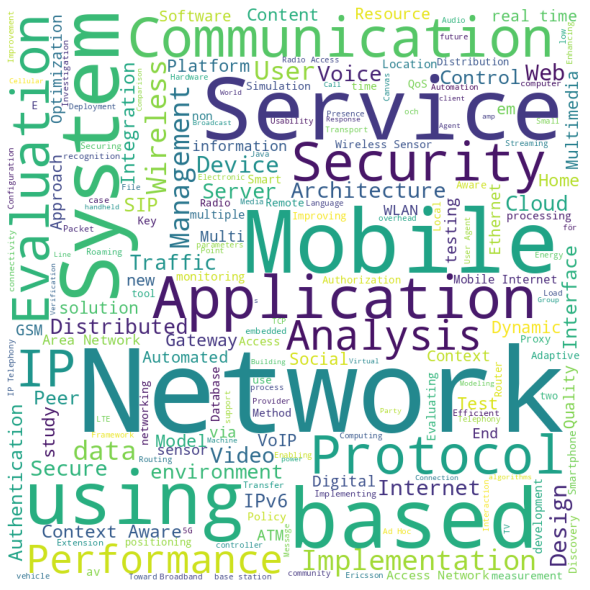

In [16]:
from wordcloud import WordCloud, STOPWORDS
title_comment_words = ''
stopwords = set(STOPWORDS)
stopwords.add('nan')

for val in df['Title']:
    val = str(val)
    # split the value which is in format: first title (second title)
    openning_paren=val.find('(')
    ending_paren=val.find(')')
    if openning_paren > 0 and ending_paren > 0 and (ending_paren-openning_paren) > 0:
        tokens = val[0:openning_paren].split(' ')
    else:
        tokens = val.split(' ')

    number_of_tokens=len(tokens)
    #print("number_of_tokens={}".format(number_of_tokens))
    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    title_comment_words += " ".join(tokens)+" "
 
title_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(title_comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(title_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Make a word cloud using the second title (likely to be in Swedish)

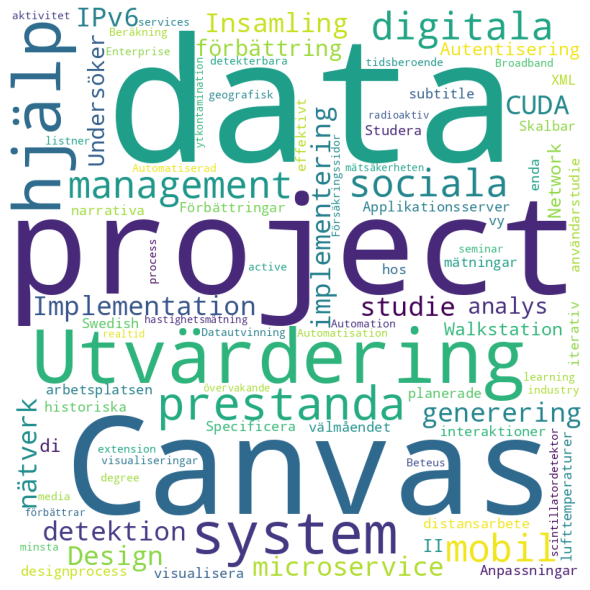

In [17]:
from wordcloud import WordCloud, STOPWORDS
title_comment_words = ''
stopwords = set(SwedishStopWords)
stopwords.update(set(STOPWORDS))
stopwords.add('nan')
stopwords.add('Language')
stopwords.add('Cooperative')

for val in df['Title']:
    val = str(val)
    # split the value first title (second title)
    openning_paren=val.find('(')
    ending_paren=val.find(')')
    if openning_paren > 0 and ending_paren > 0 and (ending_paren-openning_paren) > 0:
        tokens = val[openning_paren+1:ending_paren].split(' ')
    else:
        continue

    number_of_tokens=len(tokens)
    #print("number_of_tokens={}".format(number_of_tokens))
    # Converts each token into lowercase
    for i in range(len(tokens)):
        if any(map(str.isupper, tokens[i])):
            tokens[i] = tokens[i]
        else:
            tokens[i] = tokens[i].lower()
     
    title_comment_words += " ".join(tokens)+" "
 
title_wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(title_comment_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(title_wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

## Some statistics about defense dates - totals by year, month, date, and hour

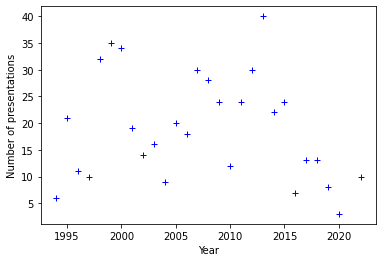

In [50]:
# dates_df has columns 'Year' and 'DefenceDate'
total_defenses_per_year=dict()
def increment_per_year(y):
    global total_defenses_per_year
    current_total=total_defenses_per_year.get(y, 0)
    total_defenses_per_year[y]=current_total+1
    #print("{0}: {1}".format(y, current_total))

total_defenses_per_month=dict()
def increment_per_month(m):
    global total_defenses_per_month
    current_total=total_defenses_per_month.get(m, 0)
    total_defenses_per_month[m]=current_total+1

total_defenses_per_day=dict()
def increment_per_day(d):
    global total_defenses_per_day
    current_total=total_defenses_per_day.get(d, 0)
    total_defenses_per_day[d]=current_total+1

total_defenses_per_hour=dict()
def increment_per_hour(h):
    global total_defenses_per_hour
    current_total=total_defenses_per_hour.get(h, 0)
    total_defenses_per_hour[h]=current_total+1

for idx, row in dates_df.iterrows():
    defense_date=row['DefenceDate']
    if type(defense_date) is pd.Timestamp and defense_date.year > 1990:
        dates_df.loc[idx,'DefenceDate year']=defense_date.year
        increment_per_year(defense_date.year)
        dates_df.loc[idx,'DefenceDate month']=defense_date.month
        increment_per_month(defense_date.month)
        dates_df.loc[idx,'DefenceDate day']=defense_date.day
        increment_per_day(defense_date.day)
        dates_df.loc[idx,'DefenceDate hour']=defense_date.hour
        increment_per_hour(defense_date.hour)

lists = sorted(total_defenses_per_year.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, 'b+')
plt.xlabel("Year")
plt.ylabel("Number of presentations")
plt.show()


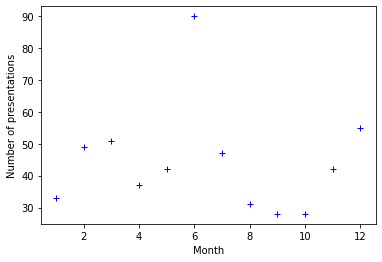

In [51]:
lists = sorted(total_defenses_per_month.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, 'b+')
plt.xlabel("Month")
plt.ylabel("Number of presentations")
plt.show()


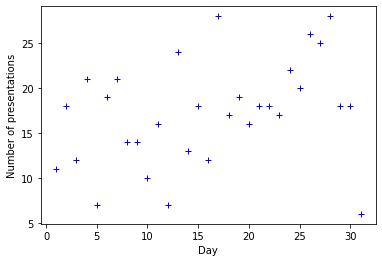

In [52]:
lists = sorted(total_defenses_per_day.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, 'b+')
plt.xlabel("Day")
plt.ylabel("Number of presentations")
plt.show()


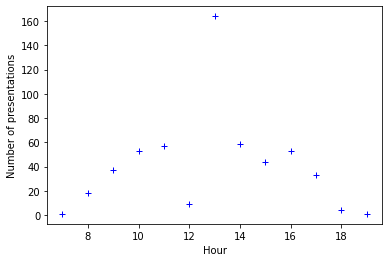

In [53]:
lists = sorted(total_defenses_per_hour.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.plot(x, y, 'b+')
plt.xlabel("Hour")
plt.ylabel("Number of presentations")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7ff901d2-2523-45e6-ad7c-a0ffb7dec8be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>